In [ ]:
!pip install torch torchaudio matplotlib scipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 77.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 63.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 60.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

100%|██████████| 427k/427k [00:00<00:00, 13.0MB/s]


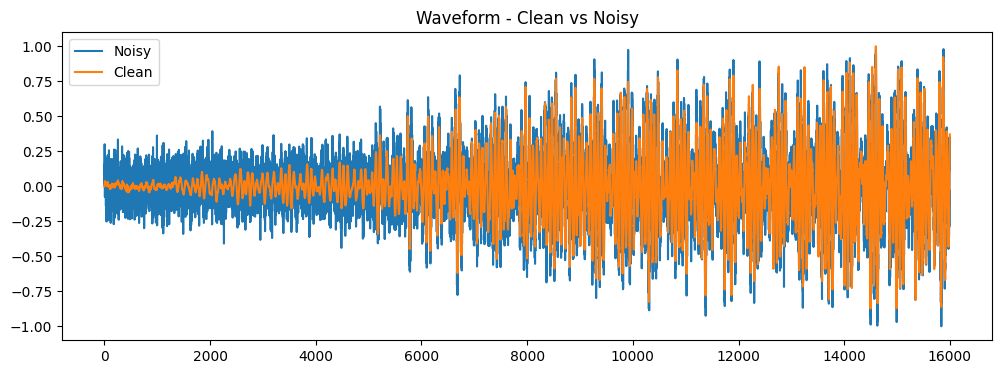

In [ ]:
import torch
import torch.nn as nn
import torchaudio
import matplotlib.pyplot as plt
import numpy as np
from scipy.io.wavfile import write

# Load an example speech signal (from torchaudio)
waveform, sample_rate = torchaudio.load(torchaudio.utils.download_asset("tutorial-assets/steam-train-whistle-daniel_simon.wav"))

# Optional: Downsample for faster training
waveform = waveform.mean(dim=0).unsqueeze(0)  # mono
waveform = waveform[:, :16000]  # limit to 1 second (16k samples)

# Add Gaussian noise
noise = 0.05 * torch.randn_like(waveform)
noisy_waveform = waveform + noise

# Normalize to [-1, 1]
waveform = waveform / waveform.abs().max()
noisy_waveform = noisy_waveform / noisy_waveform.abs().max()

# Plot example
plt.figure(figsize=(12, 4))
plt.plot(noisy_waveform[0].numpy(), label="Noisy")
plt.plot(waveform[0].numpy(), label="Clean")
plt.legend()
plt.title("Waveform - Clean vs Noisy")
plt.show()


In [ ]:
class AudioAutoencoder(nn.Module):
    def __init__(self):
        super(AudioAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(16000, 4000),
            nn.ReLU(),
            nn.Linear(4000, 1000),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(1000, 4000),
            nn.ReLU(),
            nn.Linear(4000, 16000),
            nn.Tanh()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In [ ]:
model = AudioAutoencoder()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

noisy_input = noisy_waveform.clone().detach()
clean_target = waveform.clone().detach()

# Flatten for linear layer
noisy_input = noisy_input.view(1, -1)
clean_target = clean_target.view(1, -1)

for epoch in range(1000):
    optimizer.zero_grad()
    output = model(noisy_input)
    loss = criterion(output, clean_target)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.6f}")


Epoch 0, Loss: 0.077318
Epoch 100, Loss: 0.000000
Epoch 200, Loss: 0.000010
Epoch 300, Loss: 0.000000
Epoch 400, Loss: 0.000000
Epoch 500, Loss: 0.000000
Epoch 600, Loss: 0.000000
Epoch 700, Loss: 0.000000
Epoch 800, Loss: 0.000002
Epoch 900, Loss: 0.000000


In [ ]:
# Convert back to waveform
denoised = output.detach().view(1, -1)

# Save as WAV to listen
write("noisy.wav", sample_rate, noisy_input.view(-1).numpy())
write("denoised.wav", sample_rate, denoised.view(-1).numpy())
write("original.wav", sample_rate, clean_target.view(-1).numpy())

print("Audio files saved: noisy.wav, denoised.wav, original.wav")


Audio files saved: noisy.wav, denoised.wav, original.wav


In [ ]:
from IPython.display import Audio

# Noisy input
print("🔊 Noisy Input")
display(Audio("noisy.wav"))

# Autoencoder output
print("🔊 Denoised Output")
display(Audio("denoised.wav"))

# Ground truth clean signal
print("🔊 Original Clean Audio")
display(Audio("original.wav"))


🔊 Noisy Input


🔊 Denoised Output


🔊 Original Clean Audio
